<a href="https://colab.research.google.com/github/jodejetalo99/Datos-Masivos/blob/master/Mini_Proyecto4_DM2_JJTL_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Universidad Nacional Autónoma de México
# Instituto de Investigaciones en Matemáticas Aplicadas y en Sistemas
# Datos Masivos II
# José de Jesús Tapia López
# Mini-proyecto4: Desarrollo de un sistema de recomendación.
# 20 de Enero del 2021


## Objetivo del mini-proyecto: 
Dado el conjunto de datos que te fue asignado, desarrolla y evalúa un sistema de recomendación. De los métodos que se analizaron dentro de la unidad 4, selecciona el método que tu prefieras (basado en contenido, filtrado colaborativo o learning-to rank) es importante que justifiques el método de tu selección, por ejemplo en algunas base de datos es más apropiado usar filtrado colaborativo , sin embargo en algunas bases de datos este método no es el ideal.

## Base de datos asignada: [Netflix_combined_data_3](https://www.kaggle.com/laowingkin/netflix-movie-recommendation/data)

### Entendimiento de los datos

Este conjunto de datos se construyó para apoyar a los participantes del Premio Netflix.
* Los archivos de clasificación de películas contienen más de 100 millones de clasificaciones de 480 mil clientes de Netflix anónimos y elegidos al azar en más de 17 mil títulos de películas. 

* Los datos fueron recolectados entre octubre de 1998 y diciembre de 2005 y reflejan la distribución de todas las calificaciones recibidas durante este período. Las calificaciones están en una escala de 1 a 5 estrellas (enteros). 
* Para proteger la privacidad del cliente, cada uno ha sido reemplazado por un id asignado al azar. La fecha de cada calificación y
*  También se proporcionan el título y el año de lanzamiento de cada id de película.

Cada línea subsiguiente del archivo corresponde a una calificación de un cliente y su fecha en el siguiente formato: **CustomerID, calificación, fecha**

- MovieIDs varían de 1 a 17770 secuencialmente.

- Los ID de cliente van de 1 a 2649429, con espacios. Hay 480189 usuarios.

- Las calificaciones están en una escala de cinco estrellas (integral) de 1 a 5.

- Las fechas tienen el formato AAAA-MM-DD.

La información de la película en "movie_titles.txt" tiene el siguiente formato: **MovieID, YearOfRelease, Título**

- MovieID corresponde con los ID de películas de Netflix o los ID de películas IMDB reales.

- YearOfRelease puede oscilar entre 1890 y 2005 y puede corresponder al lanzamiento de DVD correspondiente, no necesariamente su lanzamiento teatral.

- Title es el título de la película de Netflix y puede no corresponder a títulos utilizados en otros sitios. Los títulos están en inglés.


In [ ]:
!pip install surprise

In [ ]:
import numpy as np
import pandas as pd
from google.colab import drive
from matplotlib import pyplot as plt
import math
import re
from scipy.sparse import csr_matrix
import seaborn as sns
from surprise import Reader, Dataset, SVD
import time
from surprise.model_selection import cross_validate
from scipy.sparse import coo_matrix
from numpy.linalg import norm


drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# leemos el txt, de tal forma que el delimitador sea el que está por defecto, no ponemos
# encabezado, nombramos las columnas e indicamos que solo usemos las primeras dos, ya que
# la tercera contiene información de la fecha y esta no es útil para los fines del mini-proyecto
df = pd.read_csv('drive/My Drive/combined_data_3.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])
df.head()

,Cust_Id,Rating
0,9211:,NaN
1,1277134,1.0
2,2435457,2.0
3,2338545,3.0
4,2218269,1.0


### Análisis exploratorio

In [ ]:
# Ahora mostramos la dimensión de esta base de datos
df.shape

(22605786, 2)

Podemos observar que tenemos un total de 22,605,786 renglones con 2 columnas.

Ahora vamos a mostrar cuántas calificaciones hay en la base de datos, así como los usuarios y películas distintos: 

In [ ]:
# contamos los nulos que tiene la columna de Rating, ya que en la forma
# en que leímos la base de datos, esos corresponden a las películas y no realmente
# al ID del cliente
cant_pelis = df.isnull().sum()[1] 
print("El número de películas distintas es: ", cant_pelis)

# Obtenemos la cantidad de clientes distintos. Contamos los registros únicos
# de la columna de "Cust_ID" pero le restamos la cantidad de películas, ya que
#  dijimos anteriormente que hay renglones en esa columna que corresponden a películas
cant_clientes = df['Cust_Id'].nunique() - cant_pelis
print("El número de clientes distintos es: ", cant_clientes)


# Obtenemos la cantidad de calificaciones. Contamos los registros
# de la columna de "Cust_ID" pero le restamos la cantidad de pelíículas, ya que
# dijimos anteriormente que hay renglones en esa columna que corresponden a películas
cant_calif = df['Cust_Id'].count() - cant_pelis
print("La cantidad total de calificaciones es: ", cant_calif)


El número de películas distintas es:  4157
El número de clientes distintos es:  474662
La cantidad total de calificaciones es:  22601629


A continuación mostramos la frecuencia relativa de cada calificación, es decir, el porcentaje de estas:

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f0894ddf588>],
      dtype=object)

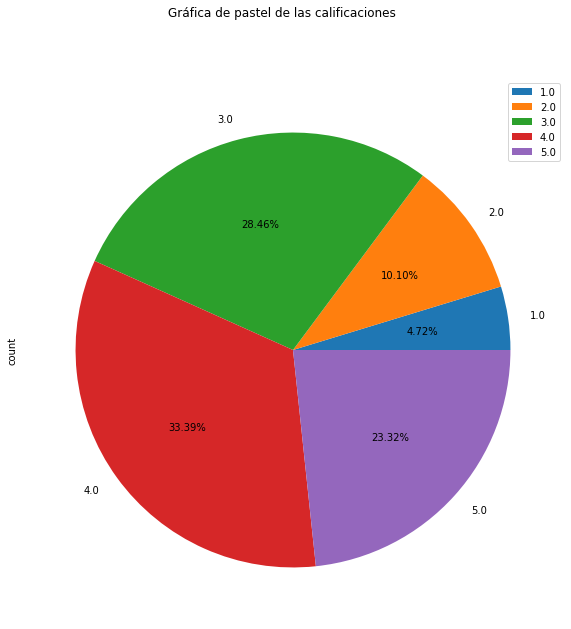

In [ ]:
df.groupby('Rating')['Rating'].agg(['count']).plot.pie(autopct="%.2f%%", subplots=True, figsize=(12,10), title='Gráfica de pastel de las calificaciones')

De la gráfica anterior podemos observar que poco más de la mitad de las calificaciones son positivas, pues el $(33.39\% +23.32\%)= 56.71\%$ corresponde a calificaciones mayores 3.

### Pre-procesamiento de los datos

Lo que sigue es crear una matriz de numpy con la longitud correcta y luego agregar toda la matriz como columna en el dataframe

In [ ]:
"""Crear una matriz de numpy para el ID de la película (procesamiento más eficiente)"""
# Convertimos a dataframe la serie que indica (con True o False) si cada renglon de la 
# base de datos tiene un nulo en la columna de Rating, esto para saber cuáles son películas
df_nan = pd.DataFrame(pd.isnull(df.Rating))
# Ahora nos quedamos con los registros (del dataframe que acabamos de crear) que tengan un
# nulo en la columna de rating
df_nan = df_nan[df_nan['Rating'] == True]
# reseteamos el indice del dataframe para que tengamos la columna de index que indica el ID
# de la película
df_nan = df_nan.reset_index()

# creamos una lista vacía para irle agregandole las peliculas
movie_np = []
# empezamos con el indice 1 de las películas
movie_id = 1

# mapeamos los valores del indice de la pelicula para ir llenando la matriz de numpy
for i,j in zip(df_nan['index'][1:],df_nan['index'][:-1]):
    # matriz de numpy
    temp = np.full((1,i-j-1), movie_id)
    movie_np = np.append(movie_np, temp)
    movie_id += 1

# Se toma en cuenta el último registro y la longitud correspondiente
last_record = np.full((1,len(df) - df_nan.iloc[-1, 0] - 1),movie_id)
movie_np = np.append(movie_np, last_record)

print('Películas (numpy): {}'.format(movie_np))
print('Tamaño: {}'.format(len(movie_np)))

Películas (numpy): [1.000e+00 1.000e+00 1.000e+00 ... 4.157e+03 4.157e+03 4.157e+03]
Tamaño: 22601629


In [ ]:
"""Visualizamos nuevamente"""

# obtenemos una serie que contiene a los renglones sin valores nulos en Rating
# y le agregamos a dicho renglon el id de la película (esto lo hacemos para
# eliminar los renglones que son de ID de películas)
df = df[pd.notnull(df['Rating'])]
# creamos la columna que contiene el id de la película de la repectva calificación
# del usuario
df['Movie_Id'] = movie_np.astype(int)
df['Cust_Id'] = df['Cust_Id'] .astype(int)

print('-Dataset examples-')
print(df.iloc[::5000000, :])



-Dataset examples-
          Cust_Id  Rating  Movie_Id
1         1277134     1.0         1
5001019    361439     4.0      1019
10001942   488142     5.0      1942
15002874  1572917     4.0      2874
20003671   550725     3.0      3671


Ahora podemos aprovechar esto para ver cuáles son los primeros 10 usuarios que más calificaciones dan a las películas y las 10 películas que más calificaciones tienen en esta base de datos:

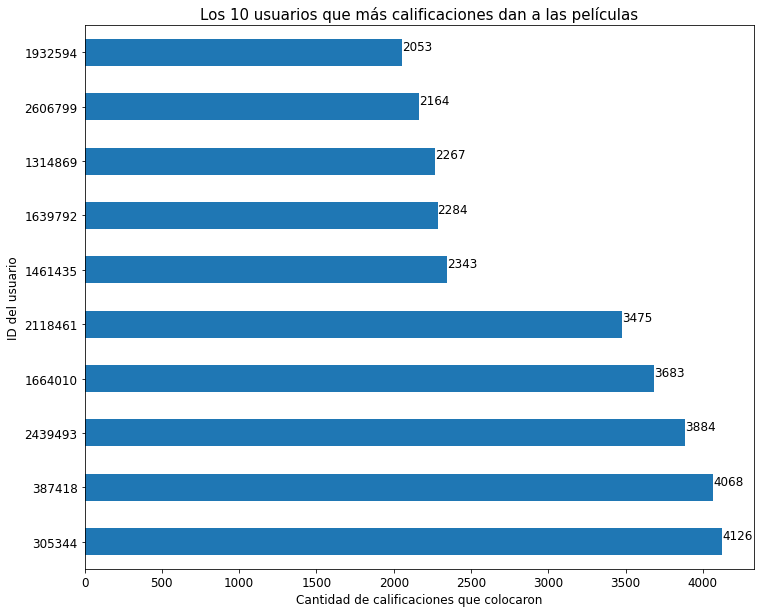

In [ ]:
# contamos el número de usuarios que más calificaciones han dado
# y los ordenamos descendentemente
frecuencia_usuarios = df.groupby("Cust_Id")['Movie_Id'].count().sort_values(ascending=False)
# obtenemos los primeros 10 que más calificaciones han hecho
frecuencia_usuarios_10 = frecuencia_usuarios[0:10]
plt.figure(figsize=(12,10))
ax = frecuencia_usuarios_10.plot(kind = 'barh')
ax.set_title("Los 10 usuarios que más calificaciones dan a las películas",fontsize=15)
ax.set_ylabel("ID del usuario",fontsize=12)
ax.set_xlabel("Cantidad de calificaciones que colocaron", fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=12)
for i in ax.patches:
    ax.text(i.get_width()+.09, i.get_y()+.3, str(round((i.get_width()), 1)), fontsize=12)

Vemos que el usuario de ID 305344 es el que más calificaciones ha hecho con 4126. En segunda lugar fue el usuario de 387418 con 4068 y en tercer lugar es el usuario de ID 2439493 con 3884. Al parecer han visto muchas películas.

Ahora vamos a cargar la base de datos que contiene el nombre de las películas, para mostrar la gráfica que contiene a aquellas que más calificaciones reciben en la base de datos de *ratings* de las películas:

In [ ]:
"""Carga de la base de datos de películas, sin encabezado pero con nombre de las columnas: Movie_Id, Year, Name, """
df_title = pd.read_csv('drive/My Drive/movie_titles.csv', encoding = "ISO-8859-1", header = None, 
                       names = ['Movie_Id', 'Year', 'Name'])
# indicamos que el indice de este dataframe sea el id de las peliculas
df_title.set_index('Movie_Id', inplace = True)
# mostramos los primeros 10 registros del dataframe que contiene información de las películas
df_title.head(10)

,Year,Name
Movie_Id,,
1,2003.0,Dinosaur Planet
2,2004.0,Isle of Man TT 2004 Review
3,1997.0,Character
4,1994.0,Paula Abdul's Get Up & Dance
5,2004.0,The Rise and Fall of ECW
6,1997.0,Sick
7,1992.0,8 Man
8,2004.0,What the #$*! Do We Know!?
9,1991.0,Class of Nuke 'Em High 2


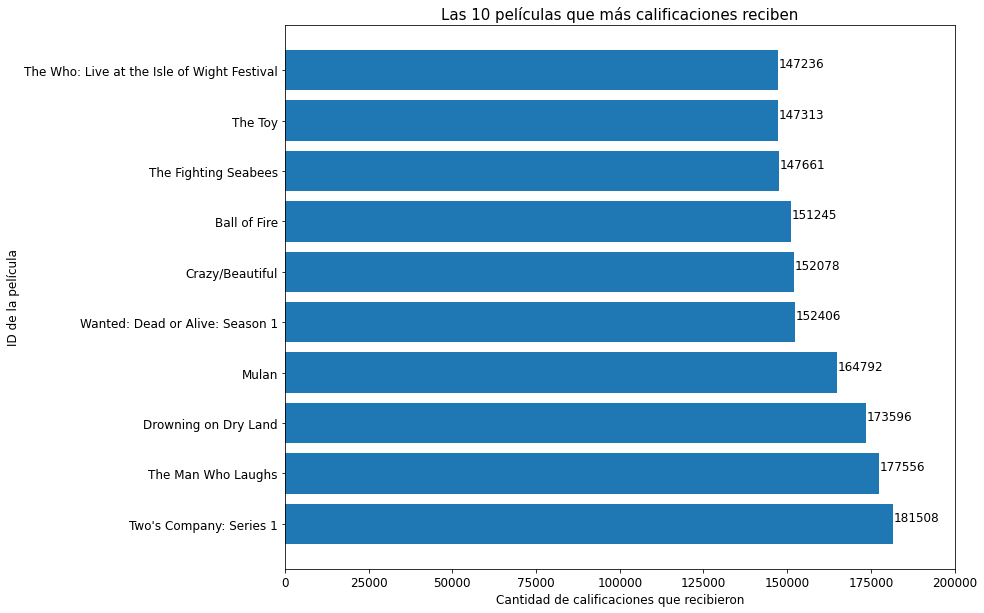

In [ ]:
# contamos el número de películas que más calificaciones reciben
# y los ordenamos descendentemente
frecuencia_pelis = df.groupby("Movie_Id")['Cust_Id'].count().sort_values(ascending=False)
# obtenemos los ID's de las primeras 10 que más calificaciones han hecho
frecuencia_pelis_10 = list(frecuencia_pelis[0:10].keys())
# obtenemos la frecuencia de cada uno
frec_val_pelis_10 = frecuencia_pelis[0:10].values
# ahora usamos estos ID's para obtener el nombre de la película con cada uno
frecuencia_pelis_10 = [df_title.loc[x]['Name'] for x in frecuencia_pelis_10]
plt.figure(figsize=(12,10))
bar = plt.barh(frecuencia_pelis_10, frec_val_pelis_10)
plt.title("Las 10 películas que más calificaciones reciben",fontsize=15)
plt.ylabel("ID de la película", fontsize=12)
plt.xlim(0,200000)
plt.xlabel("Cantidad de calificaciones que recibieron",fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
for rect in bar:
    width = rect.get_width()
    plt.text(width+7000, rect.get_y() + rect.get_height()/2.0, '%d' % int(width), ha='center', va='bottom', fontsize=12)

Vemos que *Two's Company: Series 1* es la que más calificaciones recibe con 181508. En segunda lugar fue la película *The Man Who Laughs* con 177556 y en tercer lugar fue la película *Drowning on Dry Land* con 173596.

### División de los datos

Dado que el conjunto de datos ahora es muy grande, lo que sigue es:

* Eliminar películas con menos ratings (relativamente no son populares)
* Eliminar a los usuarios que dieron menos reseñas (son relativamente menos activos)

In [ ]:
# Agrupamos por id de la película y a cada una de ella le calculamos el total
# de veces que fue calificada y el promedio de su calificación
df_movie_summary = df.groupby('Movie_Id')['Rating'].agg(['count','mean'])
# redondeamos (0 decimales) el valor dado del cuantil de orden 70%
movie_benchmark = round(df_movie_summary['count'].quantile(0.7),0)
# nos quedamos con los indices de las peliculas que son menores al valor del cuantil anterior
drop_movie_list = df_movie_summary[df_movie_summary['count'] < movie_benchmark].index

print('Películas menos populares: {}'.format(movie_benchmark))

# Agrupamos por id del cliente y a cada uno de ellos le calculamos el total
# de veces que calificó y el promedio de las calificaciones que hizo
df_cust_summary = df.groupby('Cust_Id')['Rating'].agg(['count','mean'])
# redondeamos (0 decimales) el valor dado del cuantil de orden 70%
cust_benchmark = round(df_cust_summary['count'].quantile(0.7),0)
# nos quedamos con los indices de los clientes que son menores al cuantil
drop_cust_list = df_cust_summary[df_cust_summary['count'] < cust_benchmark].index

print('Usuarios menos activos: {}'.format(cust_benchmark))

Películas menos populares: 1908.0
Usuarios menos activos: 48.0


En seguida revisamos la base de datos, después de reducirla:



In [ ]:
print('Tamaño original: {}'.format(df.shape))
df = df[~df['Movie_Id'].isin(drop_movie_list)]
df = df[~df['Cust_Id'].isin(drop_cust_list)]
print('Tamaño después de la reducción: {}'.format(df.shape))
print('-Data Examples-')
print(df.iloc[::5000000, :])

Tamaño original: (22601629, 3)
Tamaño después de la reducción: (16008083, 3)
-Data Examples-
          Cust_Id  Rating  Movie_Id
2561       306466     2.0         7
6964285   2555377     4.0      1397
14073380  1475279     3.0      2678
21130651   982635     4.0      3842


Observamos que ahora tenemos un $\dfrac{16,008,083}{22,601,629} = 70.83\%$ de la información original.

Generamos una tabla pivote para que las columnas correspondan al ID de la película, los renglones sean el ID del cliente o usuario y los valores de la tabla sean los ratings que el usuario le ha dado a la película (si no le ha dado una calificación el usuario, aparece un valor *NaN*). Esto lo necesitamos para nuestro sistema de recomendación.

In [ ]:
"""Generar una tabla pivote"""
df_p = pd.pivot_table(df,values='Rating',index='Cust_Id',columns='Movie_Id')
#df_p = pd.pivot_table(df,values='Rating',index='Cust_Id',columns='Movie_Id').fillna(0)

print(" La dimensión de la tabla pivote es: ", df_p.shape)

 La dimensión de la tabla pivote es:  (143119, 1248)


In [ ]:
#visualizamos como matriz los datos de la tabla
df_p.values

array([[ 2., nan, nan, ..., nan,  1., nan],
       [ 5., nan, nan, ..., nan,  4., nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan,  2., nan],
       [nan, nan, nan, ...,  4.,  3., nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [ ]:
"""Extracción de usuarios y libros para representarlos como listas (y las reservamos) """
cust_lista = list(df_p.index)
peli_lista = list(df_p.columns)

In [ ]:

# Construimos una matriz dispersa con los valores de la matriz anterior
R = coo_matrix(df_p.values)
print("Tamaño de la matriz dispersa", R.shape)


Tamaño de la matriz dispersa (143119, 1248)


Una vez que todos los datos requeridos están cargados y limpiados, empezamos ahora sí con el sistema de recomendación.

### Sistema de Recomendación usando el filtrado colaborativo

¿Por qué utilizamos este método? Porque el filtrado colaborativo es un método para hacer predicciones automáticas (filtrado) sobre los intereses de un usuario mediante la recopilación de las preferencias o gustos de información de muchos usuarios (colaborador)

El Filtrado colaborativo se basa, en que si una persona A tiene la misma opinión que una persona B sobre un tema, A es más probable que tenga la misma opinión que B en otro tema diferente que la opinión que tendría una persona elegida azar. Por ello, la similitud entre usuarios puede ser usada para inferir
las calificaciones no observadas; la mayoría de los modelos de filtrado colaborativo aprovechan las correlaciones (similitudes) entre los gustos de películas en los usuarios.

Además, esto ayuda pues las calificaciones están en una escala de Likert (1-5).

Usamos la biblioteca [Surprise](http://surpriselib.com/) y se emplea el algoritmo de [factorización de matrices probabilísticas](https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD).



Antes de continuar, vamos a mostrar las películas que le hayan gustado al usuario 1117, que es al quien le haremos recomendaciones de películas.

In [ ]:
# Seleccionamos la información de las películas que le hayan gustado al usuario con ID 1117
df_1117 = df[(df['Cust_Id'] == 1117) & (df['Rating'] == 5)]
# indicamos que el indice de este df sea el ID de la pelicula
df_1117 = df_1117.set_index('Movie_Id')
# hacemos un join mediante el ID de la pelicula con su nombre (ya que
# el nombre no se presenta en la primera base de datos que cargamos)
df_1117 = df_1117.join(df_title)['Name']
print(df_1117) #Estas son las películas que ha visto y le han gustado

Movie_Id
1208                   The Twilight Zone: Vol. 15
1854                              Crazy/Beautiful
1942                    REO Speedwagon: Live Plus
1981                                  Needing You
2073                      Two's Company: Series 1
2602                                 Stuck on You
3283                         Cadfael: Monk's Hood
4045    The Indiana Jones Trilogy: Bonus Material
Name: Name, dtype: object


Vamos a utilizar dos métodos para comparar las recomendaciones que nos arrojan ambos para el usuario con ID 1117

#### Factor Latente

In [ ]:
"""Inicializar las matrices U y V"""
M, N = R.shape
print("Tamaño de las matrices M y N: ", M,N)
K = 3 #no. de factores a calcular

U=np.random.rand(M,K) #inicializar la matriz U
V=np.random.rand(K,N) #inicalizar la matriz V

print("Tamaño de la matriz U: ", U.shape)
print(U)
print("Tamaño de la matriz V: ", V.shape)
print(V)

Tamaño de las matrices M y N:  143119 1248
Tamaño de la matriz U:  (143119, 3)
[[0.23166926 0.71258439 0.72997839]
 [0.22611214 0.08115321 0.15152758]
 [0.89418689 0.48719729 0.52493928]
 ...
 [0.17640947 0.69564281 0.72198464]
 [0.44746805 0.28533174 0.81876097]
 [0.73169046 0.88300051 0.09525982]]
Tamaño de la matriz V:  (3, 1248)
[[0.41104594 0.26449267 0.72956562 ... 0.96918491 0.65604794 0.71633526]
 [0.09496622 0.55655215 0.45862495 ... 0.28399091 0.22169371 0.34425731]
 [0.94987769 0.70582398 0.49601053 ... 0.23364846 0.28335643 0.7932408 ]]


In [ ]:
"""Función para calcular el error cuadrático"""

def error(R,U,V,lamda=0.02):
    ratings = R.data
    filas = R.row
    columnas = R.col
    e = 0 
    for ui in range(len(ratings)):
        rui=ratings[ui]
        u = filas[ui]
        i = columnas[ui]
        if rui>0:
            e= e + pow(rui-np.dot(U[u,:],V[:,i]),2)+\
                lamda*(pow(norm(U[u,:]),2)+pow(norm(V[:,i]),2))
    return e

In [ ]:
#Calcular el error

#tiempo para observar cuanto se tarda en ejecutarse la celda
t1 = time.time()
rmse = np.sqrt(error(R,U,V)/len(R.data))
print("RMSE: ", rmse)
print("Tiempo de ejecuación RMSE (en segundos):", time.time() - t1) # aprox 5 minutos

RMSE:  0.9193753691027149
Tiempo de ejecuación del RMSE (en segundos): 386.4318265914917


In [ ]:
"""Función para optimizar las matrices U y V usando el SGD"""

def SGD(R, K, lamda=0.02,steps=10, gamma=0.001):
    M,N = R.shape
    U = np.random.rand(M,K)
    V = np.random.rand(K,N)
    
    rmse = np.sqrt(error(R,U,V,lamda)/len(R.data))
    print("RMSE inicial: "+str(rmse))
    
    for step in range(steps):
        for ui in range(len(R.data)):
            rui=R.data[ui]
            u = R.row[ui]
            i = R.col[ui]
            if rui>0:
                eui=rui-np.dot(U[u,:],V[:,i])
                U[u,:]=U[u,:]+gamma*2*(eui*V[:,i]-lamda*U[u,:])
                V[:,i]=V[:,i]+gamma*2*(eui*U[u,:]-lamda*V[:,i])
        rmse = np.sqrt(error(R,U,V,lamda)/len(R.data))
        if rmse<0.5:
            break
    print("RMSE final: "+str(rmse))
    return U,V

In [ ]:
#tiempo para observar cuanto se tarda en ejecutarse la celda
t1 = time.time()
U,V=SGD(R,K=3,gamma=0.0007,lamda=0.001, steps=500)
print("Tiempo de ejecuación del RMSE con SGD (en segundos):", time.time() - t1) # tarda aprox 20 minutos

RMSE inicial: 0.9163282993892183
RMSE final: 0.30734966438659694
Tiempo de ejecuación del RMSE (en segundos): 1177.3839900493622


In [ ]:
#Generar las predicciones para todos los usuarios
pred_user_ratings =np.matmul(U, V) # multiplicacion de U por V como lo vimos en clase
pred_user_ratings

array([[4.84853113, 4.71985941, 4.47877376, ..., 4.6960353 , 5.19797066,
        4.5154739 ],
       [4.88195559, 4.76251386, 4.30748816, ..., 4.68739607, 5.1756225 ,
        4.57550084],
       [5.21421669, 4.86427582, 4.58584573, ..., 4.90413453, 5.45033904,
        4.69770905],
       ...,
       [2.82189642, 2.61351676, 2.68457069, ..., 2.69127582, 3.00512779,
        2.50579744],
       [3.72965829, 3.75801751, 3.37521018, ..., 3.65325094, 4.01897562,
        3.58965269],
       [3.73926342, 3.53993609, 3.29461492, ..., 3.54121132, 3.92736488,
        3.41253084]])

In [ ]:
"""Convertir la matriz reconstruida a dataframe"""
# las columnas son el ID de las peliculas, el indice de los renglones es el id de los clientes, y los valores
# del dataframe son las predicciones para todos los usuarios de los ratings
df_pred_user_ratings = pd.DataFrame(np.round(pred_user_ratings,2),columns=peli_lista, index=cust_lista)#redondear los ratings a 2 dígitos
print("Tamaño de la matriz reconstruida: ", df_pred_user_ratings.shape)

Tamaño de la matriz reconstruida:  (143119, 1248)


Recordemos:

El dataframe 'df_pred_user_ratings' es la matriz reconstruida de $U \cdot V$, donde: $M$ es el número de usuarios y $N$ es el número de productos.

Cada $r_{ij}$ es la predicción del usuario $i$ para el libro $j$.

Cuando $r_{ij}$ tiene un valor alto indica una alta probabilidad que el usuario compre un libro

In [ ]:
#Visualizar la matriz reconstruida
df_pred_user_ratings.head(10)

,7,8,12,13,14,18,19,21,22,24,25,26,27,28,30,31,32,44,47,50,52,55,64,66,69,78,84,85,86,88,93,99,100,110,113,116,117,119,120,121,...,3997,4001,4004,4006,4007,4009,4017,4020,4022,4024,4034,4038,4041,4044,4045,4051,4059,4060,4063,4066,4069,4070,4072,4078,4083,4088,4091,4092,4094,4101,4103,4107,4108,4109,4116,4117,4118,4132,4149,4155
6,4.849,4.720,4.479,4.020,5.009,4.963,4.875,4.493,4.093,4.432,4.924,5.764,4.859,3.746,4.806,4.944,5.436,5.561,4.120,4.826,3.750,4.827,5.405,4.200,4.682,4.420,4.735,5.229,5.100,4.805,4.315,4.097,4.912,5.218,4.353,5.859,5.557,4.765,5.695,3.639,...,5.720,4.447,4.029,4.791,5.218,5.445,4.764,5.309,4.390,4.334,4.743,4.326,5.443,4.230,5.803,4.609,5.309,5.314,5.437,4.832,4.698,3.423,4.136,3.993,4.840,4.940,5.955,5.922,4.984,4.428,5.089,4.567,4.609,3.751,5.478,4.246,4.928,4.696,5.198,4.515
7,4.882,4.763,4.307,4.123,4.906,5.044,4.872,4.342,4.074,4.433,4.889,5.793,4.784,4.021,4.753,4.956,5.357,5.515,3.955,4.737,3.947,4.799,5.332,4.025,4.652,4.470,4.778,5.211,4.952,4.815,4.223,4.046,4.937,5.225,4.301,5.920,5.421,4.744,5.697,3.605,...,5.678,4.445,4.098,4.761,5.186,5.487,4.645,5.187,4.292,4.306,4.759,4.308,5.413,4.318,5.780,4.548,5.299,5.291,5.452,4.843,4.948,3.441,4.173,3.942,4.850,4.894,5.944,5.913,5.039,4.419,5.218,4.638,4.594,3.756,5.425,4.250,4.886,4.687,5.176,4.576
10,5.214,4.864,4.586,4.298,5.201,5.197,5.095,4.679,4.339,4.639,5.152,5.996,5.073,4.229,4.987,5.141,5.630,5.802,4.426,5.247,4.231,5.052,5.820,4.416,4.879,4.791,4.961,5.512,5.521,5.047,4.699,4.322,5.170,5.539,4.486,6.043,5.963,5.113,5.924,3.668,...,6.009,4.659,4.439,5.061,5.452,5.591,4.870,5.689,4.591,4.399,5.091,4.453,5.690,4.266,6.111,4.636,5.681,5.742,5.747,5.025,5.067,3.562,4.499,4.245,5.110,5.168,6.257,6.205,5.485,4.675,5.453,5.074,4.826,3.900,5.543,4.410,5.213,4.904,5.450,4.698
79,6.126,5.861,5.276,5.162,6.053,6.254,6.033,5.363,5.078,5.492,6.056,7.158,5.919,5.159,5.864,6.123,6.602,6.822,4.958,5.974,5.065,5.946,6.694,4.993,5.751,5.630,5.925,6.478,6.232,5.976,5.330,5.030,6.134,6.518,5.289,7.287,6.794,5.946,7.039,4.388,...,7.046,5.510,5.202,5.923,6.420,6.740,5.688,6.497,5.313,5.259,5.967,5.296,6.702,5.264,7.181,5.530,6.633,6.654,6.787,5.983,6.220,4.252,5.265,4.920,6.034,6.061,7.377,7.329,6.393,5.497,6.539,5.910,5.693,4.641,6.616,5.247,6.083,5.802,6.418,5.655
97,5.676,5.443,5.171,4.690,5.804,5.752,5.653,5.215,4.771,5.142,5.715,6.671,5.638,4.442,5.563,5.722,6.290,6.448,4.837,5.681,4.452,5.603,6.339,4.894,5.426,5.188,5.492,6.083,5.999,5.580,5.084,4.770,5.708,6.083,5.027,6.758,6.514,5.578,6.593,4.170,...,6.648,5.161,4.754,5.579,6.052,6.272,5.492,6.220,5.100,4.978,5.550,4.992,6.314,4.838,6.748,5.279,6.208,6.236,6.328,5.593,5.488,3.962,4.861,4.662,5.631,5.733,6.919,6.874,5.881,5.154,5.942,5.405,5.349,4.341,6.286,4.913,5.741,5.445,6.036,5.223
116,3.560,3.183,3.028,2.901,3.462,3.448,3.391,3.136,2.933,3.092,3.441,3.966,3.391,2.961,3.307,3.402,3.730,3.866,3.062,3.646,2.979,3.374,4.003,2.996,3.244,3.292,3.301,3.705,3.834,3.374,3.274,2.914,3.459,3.742,2.955,3.955,4.102,3.496,3.924,2.360,...,4.030,3.109,3.091,3.410,3.635,3.646,3.196,3.907,3.079,2.848,3.473,2.923,3.795,2.717,4.103,2.979,3.871,3.952,3.865,3.325,3.421,2.357,3.102,2.884,3.433,3.453,4.189,4.142,3.822,3.145,3.689,3.561,3.221,2.582,3.580,2.916,3.520,3.264,3.645,3.099
134,6.589,6.389,6.020,5.474,6.758,6.735,6.599,6.052,5.545,6.002,6.661,7.806,6.564,5.163,6.492,6.692,7.339,7.519,5.562,6.543,5.154,6.531,7.326,5.657,6.332,6.016,6.420,7.082,6.902,6.510,5.849,5.542,6.660,7.076,5.876,7.933,7.518,6.465,7.708,4.903,...,7.740,6.022,5.497,6.488,7.058,7.367,6.414,7.183,5.926,5.846,6.441,5.845,7.364,5.724,7.858,6.205,7.203,7.214,7.372,6.541,6.427,4.636,5.629,5.406,6.561,6.680,8.064,8.018,6.793,6.000,6.931,6.234,6.238,5.077,7.384,5.746,6.672,6.356,7.036,6.122
169,4.013,3.973,3.614,3.393,4.090,4.183,4.048,3.620,3.368,3.680,4.062,4.818,3.979,3.238,3.961,4.123,4.469,4.586,3.261,3.884,3.182,3.986,4.386,3.345,3.870,3.663,3.964,4.316,4.069,3.992,3.460,3.353,4.090,4.316,3.593,4.937,4.468,3.905,4.740,3.034,...,4.710,3.689,

Generamos las recomendaciones

In [ ]:
#Transponer la matriz reconstruida
trans_pred_user_ratings=df_pred_user_ratings.transpose()
trans_pred_user_ratings.head()

,6,7,10,79,97,116,134,169,188,195,199,201,250,265,266,268,283,291,296,298,302,304,305,358,383,424,437,462,477,481,485,527,544,561,578,592,596,602,609,614,...,2648853,2648858,2648861,2648869,2648873,2648885,2648928,2648939,2648956,2649027,2649049,2649050,2649057,2649059,2649067,2649093,2649097,2649100,2649110,2649116,2649120,2649166,2649231,2649257,2649267,2649285,2649288,2649296,2649299,2649308,2649311,2649328,2649331,2649335,2649336,2649370,2649378,2649388,2649426,2649429
7,4.849,4.882,5.214,6.126,5.676,3.560,6.589,4.013,4.814,4.487,5.532,3.927,1.376,4.479,4.698,4.363,4.094,3.033,3.646,1.977,4.743,4.502,3.170,3.184,3.405,3.510,3.056,3.134,3.710,5.192,2.720,5.003,4.487,4.044,2.213,3.769,3.223,4.967,4.616,3.071,...,2.918,4.134,3.438,3.031,3.643,3.851,3.474,4.023,3.157,3.478,3.507,3.587,3.495,3.044,3.611,2.943,2.794,3.295,3.161,3.260,3.437,2.416,3.727,3.520,3.487,3.011,3.284,3.295,3.712,3.232,3.230,3.586,3.075,3.385,3.226,3.020,2.942,2.822,3.730,3.739
8,4.720,4.763,4.864,5.861,5.443,3.183,6.389,3.973,4.551,4.393,5.056,3.814,1.280,4.268,4.534,4.121,4.075,3.114,3.296,1.802,4.354,4.266,2.881,3.067,3.225,3.376,2.787,3.078,3.494,5.187,2.673,4.957,4.161,3.792,2.097,3.414,3.040,4.798,4.423,3.010,...,2.777,3.809,3.341,2.944,3.383,3.613,3.215,3.836,2.845,3.321,3.241,3.447,3.336,3.113,3.335,2.846,2.596,3.135,2.949,3.277,3.309,2.275,3.522,3.330,3.535,2.661,3.118,3.193,3.445,3.294,2.940,3.534,3.100,3.234,2.949,2.810,2.843,2.614,3.758,3.540
12,4.479,4.307,4.586,5.276,5.171,3.028,6.020,3.614,4.426,4.006,4.938,3.459,1.194,4.097,4.283,3.966,3.564,2.648,3.116,1.712,4.262,3.827,2.654,2.814,2.917,3.269,2.696,2.927,3.344,4.705,2.368,4.611,3.945,3.681,1.911,3.398,2.989,4.570,4.217,2.716,...,2.528,3.787,2.891,2.793,3.311,3.349,3.127,3.465,2.736,2.870,2.907,3.237,3.196,2.767,3.274,2.607,2.615,3.098,2.879,2.980,2.966,2.223,3.105,2.986,3.102,2.447,3.116,2.997,3.125,2.880,2.856,3.205,2.726,3.204,3.007,2.631,2.798,2.685,3.375,3.295
13,4.020,4.123,4.298,5.162,4.690,2.901,5.474,3.393,3.931,3.781,4.482,3.310,1.138,3.681,3.895,3.576,3.516,2.650,2.983,1.618,3.842,3.790,2.622,2.668,2.858,2.880,2.483,2.601,3.046,4.403,2.318,4.195,3.686,3.300,1.853,3.027,2.619,4.106,3.808,2.599,...,2.447,3.331,2.947,2.512,2.957,3.198,2.825,3.384,2.566,2.971,2.937,2.978,2.876,2.615,2.925,2.469,2.242,2.676,2.571,2.766,2.904,1.967,3.155,2.963,3.003,2.478,2.654,2.741,3.100,2.791,2.620,3.032,2.643,2.749,2.569,2.494,2.400,2.245,3.181,3.106
14,5.009,4.906,5.201,6.053,5.804,3.462,6.758,4.090,4.941,4.543,5.554,3.940,1.361,4.588,4.809,4.447,4.091,3.049,3.560,1.948,4.784,4.407,3.060,3.198,3.349,3.640,3.045,3.263,3.761,5.319,2.714,5.173,4.471,4.122,2.187,3.803,3.325,5.114,4.727,3.092,...,2.891,4.222,3.355,3.126,3.706,3.818,3.511,3.973,3.108,3.349,3.372,3.647,3.580,3.134,3.665,2.961,2.894,3.432,3.221,3.360,3.402,2.480,3.604,3.441,3.539,2.846,3.440,3.370,3.604,3.286,3.223,3.636,3.112,3.543,3.327,2.994,3.092,2.952,3.822,3.740


Finalmente, mediante este método podemos revisar las 10 recomendaciones con mayor rating para el usuario 1117

In [ ]:


"""Visualizar el top-10 de recomendaciones de libros para el usuario: 1117"""
# obtenemos las recomendaciones (mediante los ratings) en orden descendente
df_top10 = trans_pred_user_ratings[1117.0].sort_values(ascending=False)
# seleccionamos las recomendaciones con los 10 ratings más altos
df_top10 = df_top10[:10]
# obtenemos el valor de los ratings de dichas recomendaciones
df_top10_valores = df_top10.values
# ahora usamos los ID's de las peliculas de las recomendaciones para obtener el nombre cada una
recomendaciones_df_10 = [df_title.loc[x]['Name'] for x in df_top10.keys()]
# convertimos a dataframe la informacion de las recomendaciones
pd.DataFrame({'Movie_ID': list(df_top10.keys()),
     'Movie_Title_Recommendation': recomendaciones_df_10,
     'Rating': df_top10_valores
    })


,Movie_ID,Movie_Title_Recommendation,Rating
0,2452,Lord of the Rings: The Fellowship of the Ring,4.090
1,1434,Are You Being Served? Again: The Complete Series,4.056
2,3083,Dirty Tiger,4.019
3,3320,About a Boy,3.995
4,2715,Whiteboyz,3.994
5,3727,Rich and Famous,3.993
6,1433,Casablanca: Bonus Material,3.992
7,2311,Ball of Fire,3.988
8,3624,The Last Samurai,3.980
9,3681,Hav Plenty,3.973


#### Caso Netflix

In [ ]:
# para calcular el tiempo de ejecución
t = time.time()

# Mientras cargamos un conjunto de datos personalizado, necesitamos definir un lector.
# La clase Reader se usa para analizar un archivo que contiene calificaciones. Se supone que 
# dicho archivo especifica solo una calificación por línea y cada línea debe respetar la siguiente estructura:
# usuario; articulo ; calificación; [marca de tiempo], pero esta última es opcional
reader = Reader()
#Con fines prácticos y para mejorar el rendimiento, únicamente se utilizan los primeros 100 mil registros
# se mantiene el orden del reader
data = Dataset.load_from_df(df[['Cust_Id', 'Movie_Id', 'Rating']][:100000], reader)
# instanciamos el algoritmo de SVD
svd = SVD()
# corremos 5-fold cross-validation a los 100 mil registros anteriores. Las medidas de rendimiento son 
# RMSE y MAE
sist_recom = cross_validate(svd, data, measures=['RMSE', 'MAE'])
print("Tiempo de ejecuación de la celda (en segundos):", time.time() - t)

Tiempo de ejecuación de la celda (en segundos): 28.779531478881836


In [ ]:
"""Predecir las películas que le gustaría al usuario: 1117"""
# para calcular el tiempo de ejecución
t = time.time()
# hacemos una copia del dataframe que contiene los gustos del usuario 1117
user_1117 = df_title.copy()
# reseteamos el indice del dataframe que es copia
user_1117 = user_1117.reset_index()
# quitamos  los indices de las peliculas que son menores al valor del cuantil del 70%
user_1117 = user_1117[~user_1117['Movie_Id'].isin(drop_movie_list)]

#Traemos la base de datos completa
data = Dataset.load_from_df(df[['Cust_Id', 'Movie_Id', 'Rating']], reader) 
# ajustar nuestro algoritmo a todo el conjunto de datos
trainset = data.build_full_trainset()
# Entrenamos el algoritmo en el trainset
svd.fit(trainset)

# Predecimos calificaciones para el usuario 1117
user_1117['Estimate_Score'] = user_1117['Movie_Id'].apply(lambda x: svd.predict(1117, x).est)
# eliminamos la columna con los id's de las peliculas
user_1117 = user_1117.drop('Movie_Id', axis = 1)
# ordenamos los valores de manera descendente
user_1117 = user_1117.sort_values('Estimate_Score', ascending=False)
# mostramos las primeras 10 recomendaciones de peliculas al usuario 1117
print(user_1117.head(10))
print("Tiempo de ejecuación de la predicción (en segundos):", time.time() - t) # aproximadamente tarda 18 minutos

        Year                                              Name  Estimate_Score
1915  1985.0                        Go Tell It on the Mountain        4.673158
1433  1992.0  Are You Being Served? Again: The Complete Series        4.661945
3788  1997.0                                  Thomas Jefferson        4.623275
2824  2001.0              Midsomer Murders: Ring Out Your Dead        4.516869
3680  1997.0                                        Hav Plenty        4.487804
2451  2001.0     Lord of the Rings: The Fellowship of the Ring        4.452089
3623  2003.0                                  The Last Samurai        4.447499
850   1990.0                       Back to the Future Part III        4.430490
1395  2004.0                                      Kaleido Star        4.414504
2714  1999.0                                         Whiteboyz        4.411720
Tiempo de ejecuación de la predicción (en segundos): 1053.7660410404205


## Conclusiones


De los dos métodos utilizados, observamos que con el primero obtuvimos películas con ratings prácticamente de 4, por lo que con Factor Latente probablemente esas recomendaciones no se conviertan en sus películas favoritas del usuario con ID 1117, pero sí le pueden gustar.

En cuanto al segundo método, notamos que el top 10 de recomendaciones tienen un rating entre 4.41 y 4.68.

Por lo tanto, independientemente de los ratings de las recomendaciones de ambos, considero que lo más rescatable de los métodos es comparar si es que existen películas en común, y vemos que sí las hay: *Lord of the Rings: The Fellowship of the Ring*,	*Are You Being Served? Again: The Complete Series*, *Whiteboyz*, *The Last Samurai* y *Hav Plenty*. La recomendación de película que más rating tiene es la de *Are You Being Served? Again: The Complete Series*, pues en ambos métodos ocupa el segundo lugar.

Considero que tal vez hubieran coincido aun más películas en ambos métodos si se hubieran utilizado todos  los registros en el algoritmo de *Netflix* (no solo los primeros 100 mil), pero aun asi concluimos entonces que los dos métodos son muy buenos y verdaderamente sirven para recomendar, pues no es ninguna coincidencia que concuerden en recomendaciones de determinadas películas, aun cuando no ocupan las mismas posiciones.